In [41]:
!unzip train.zip

Archive:  train.zip
  inflating: train.csv               


Koder LSTM Modellen:

In [42]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from copy import deepcopy
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [43]:
train_df = pd.read_csv('train.csv')

train_df['label'].value_counts()



label
0    29720
1     2242
Name: count, dtype: int64

In [44]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [45]:
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')

In [46]:
nltk.download('wordnet')

tokenizer = nltk.RegexpTokenizer(r"\w+")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hazaraking/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('feet')

def message_to_token_list(s):
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]

  return useful_tokens

In [48]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors, dtype=float)

In [49]:
message_to_word_vectors('@user when a father is dysfunctional and is').shape

(8, 50)

In [50]:
train_df = train_df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(22373, 4794, 4795)

In [51]:
def df_to_X_y(dff):
  y = dff['label'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['tweet']:
    message_as_vector_seq = message_to_word_vectors(message)

    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)

  return all_word_vector_sequences, y

X_train, y_train = df_to_X_y(train_df)

(array([3.493e+03, 7.017e+03, 6.723e+03, 3.786e+03, 1.182e+03, 1.610e+02,
        7.000e+00, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([ 1. ,  6.4, 11.8, 17.2, 22.6, 28. , 33.4, 38.8, 44.2, 49.6, 55. ]),
 <BarContainer object of 10 artists>)

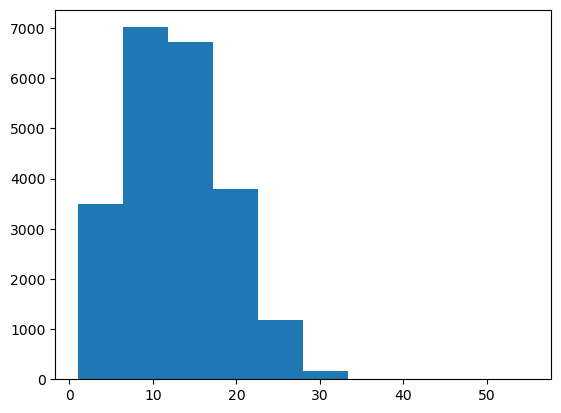

In [52]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

plt.hist(sequence_lengths)

In [53]:
pd.Series(sequence_lengths).describe()

count    22373.000000
mean        12.691727
std          5.930270
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max         55.000000
dtype: float64

In [54]:
def pad_X(X, desired_sequence_length=57):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len

    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [55]:
X_train = pad_X(X_train)

X_train.shape, y_train.shape

((22373, 57, 50), (22373,))

In [56]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)

X_val.shape, y_val.shape

((4794, 57, 50), (4794,))

In [57]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)

X_test.shape, y_test.shape

((4795, 57, 50), (4795,))

In [58]:
model = Sequential([])

model.add(layers.Input(shape=(57, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 57, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 57, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 57, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3648)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         3,649 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,137 (387.25 KB)

 Trainable params: 99,137 (387.25 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
cp = ModelCheckpoint('model/best_model.keras', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [61]:
frequencies = pd.value_counts(train_df['label'])

frequencies

/var/folders/13/bmwvm7vd0pv3v3_xymz6s4wh0000gn/T/ipykernel_9099/140418759.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frequencies = pd.value_counts(train_df['label'])


label
0    20820
1     1553
Name: count, dtype: int64

In [62]:
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.0745917387127761, 1: 14.406310367031551}

In [63]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.6575 - auc: 0.7323 - loss: 1.1930 - val_accuracy: 0.8552 - val_auc: 0.8918 - val_loss: 0.3596
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8147 - auc: 0.8923 - loss: 0.8353 - val_accuracy: 0.7958 - val_auc: 0.9039 - val_loss: 0.4592
Epoch 3/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8193 - auc: 0.9014 - loss: 0.7952 - val_accuracy: 0.8296 - val_auc: 0.9060 - val_loss: 0.3895
Epoch 4/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.8352 - auc: 0.9102 - loss: 0.7624 - val_accuracy: 0.8118 - val_auc: 0.9117 - val_loss: 0.4368
Epoch 5/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.8387 - auc: 0.9207 - loss: 0.7102 - val_accuracy: 0.8715 - val_auc: 0.9133 - val_loss: 0.3018
Epoch 6/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.8386 - auc: 0.9242 - loss: 0.6918 - val_accuracy: 0.8456 - val_auc: 0.9165 - val_loss: 0.3534
Epoch 7/20
700/700 ━━━━━━━━━

In [64]:
best_model = load_model('model/best_model.keras')

In [65]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, test_predictions))

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.89      0.93      4454
           1       0.36      0.83      0.50       341

    accuracy                           0.88      4795
   macro avg       0.67      0.86      0.72      4795
weighted avg       0.94      0.88      0.90      4795



KonfusionsMatricerne:

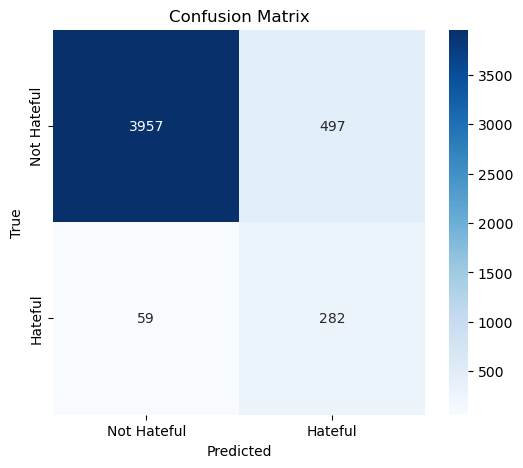

In [66]:
cm = confusion_matrix(y_test, test_predictions)

# Plot confusion matrix med Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hateful', 'Hateful'], yticklabels=['Not Hateful', 'Hateful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

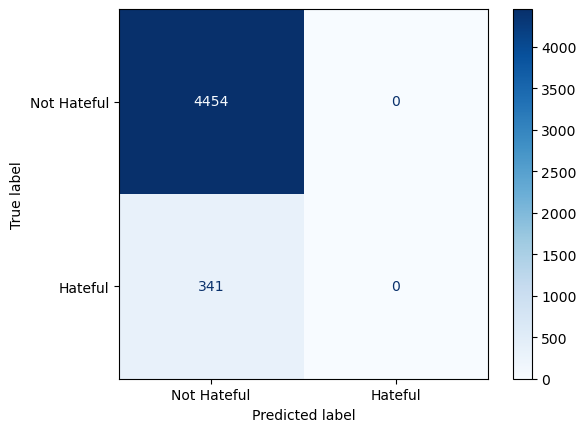

In [67]:
# Faktiske labels (ground truth)
y_true = np.array([0] * 4454 + [1] * 341)  # 4454 ikke-hadefulde og 341 hadefulde

# Baseline forudsigelser: Alt bliver forudsagt som "ikke-hadefuldt" (klasse 0)
y_pred_baseline = np.zeros_like(y_true)

# Beregn confusion matrix for baseline-modellen
cm_baseline = confusion_matrix(y_true, y_pred_baseline)

# Visualisér confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=["Not Hateful", "Hateful"])
disp.plot(cmap="Blues")